In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

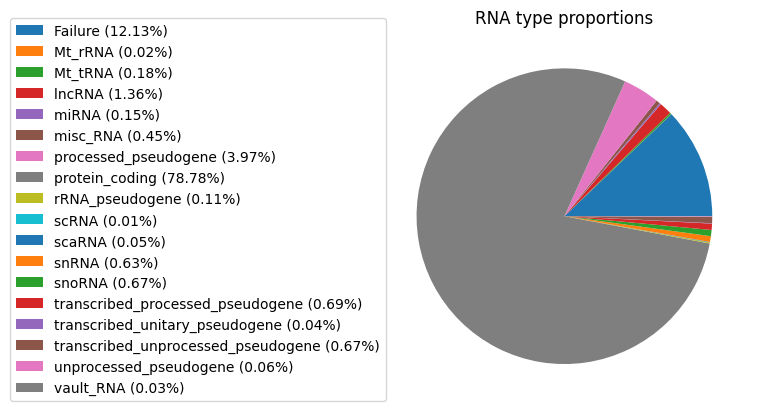

18 miRNA 
9376 protein coding mRNA


,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
MIR100,0,5,0,0,1,0,0,0,0,2,...,3,0,4,2,105,0,0,0,0,0
MIR103A2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62
MIR16-2,0,0,0,0,0,0,0,0,0,0,...,66,0,10,3,39,0,29,0,0,0
MIR199A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
MIR199A2,1,0,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
MIR221,19,0,0,0,13,0,0,0,0,0,...,0,0,0,0,51,0,2,0,0,0
MIR222,37,16,1,7,18,3,1,25,15,19,...,44,5,39,8,43,1,3,2,6,2
MIR23A,0,7,0,0,2,0,0,4,0,1,...,10,0,6,0,437,0,1,0,3,1
MIR24-2,0,2,0,0,0,0,0,0,2,0,...,3,0,12,12,28,0,0,1,1,0
MIR27A,0,5,0,0,6,2,6,10,3,1,...,0,0,1,0,0,0,0,0,1,0


In [2]:
# read fibroblast transcript counts (for all genes)
data_all_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_cleaned.csv", index_col=0)

# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# display proportions of RNA types
counts = np.unique(biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(counts[0], counts[1])])
plt.title("RNA type proportions")
plt.show()

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

print(f"{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

data_miRNA

In [3]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

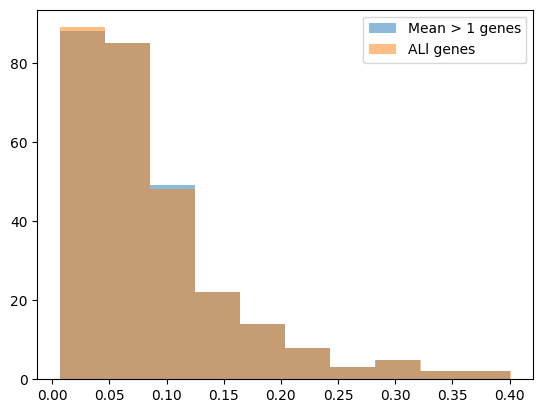

In [4]:
beta = estimate_capture(data_FIB)
beta_all = estimate_capture(data_all_FIB)
plt.hist(beta, alpha=0.5, label="Mean > 1 genes")
plt.hist(beta_all, alpha=0.5, label="ALl genes")
plt.legend()
plt.show()

4756 miRNA targets predicted
4419 are in the dataset (mean expr > 0)
2770 are in the dataset (mean expr > 1)


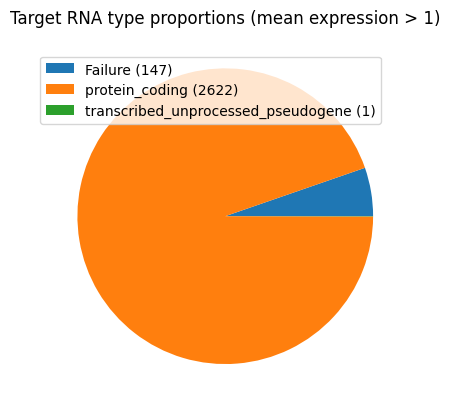

In [5]:
# load predicted targets
target_df = pd.read_csv("../../Real-Data/TargetScan/TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.txt", delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names_all = list(data_all_FIB.index)
gene_names_thresh = list(data_FIB.index)
shared_names_all = list(set(target_names) & set(gene_names_all))
shared_names_thresh = list(set(target_names) & set(gene_names_thresh))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names_all)} are in the dataset (mean expr > 0)")
print(f"{len(shared_names_thresh)} are in the dataset (mean expr > 1)")

# target biotypes
target_biotypes = []
for i, btype in biotypes_dict.items():
    if gene_names_thresh[i] in target_names:
        target_biotypes.append(btype)

# display proportions of RNA types
counts = np.unique(target_biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(0,0.75), labels=[f"{name} ({count})" for name, count in zip(counts[0], counts[1])])
plt.title("Target RNA type proportions (mean expression > 1)")
plt.show()

In [26]:
def construct_dataset(mir_sample, mRNA_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mRNA_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mir_sample
        gene_j = mRNA_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [165]:
def reduce_dataset(dataset, selected_indices):

    # size
    cells = dataset.cells
    gene_pairs = len(selected_indices)

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # construct moment bounds dict
    moment_dict = {}

    # copy over selected data
    for i, j in enumerate(selected_indices):
        counts_df.iloc[i] = dataset.count_dataset.iloc[j]
        moment_dict[f'sample-{i}'] = dataset.moment_bounds[f'sample-{j}']

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = dataset.resamples

    # set capture
    data.beta = dataset.beta

    # set moments
    data.moment_bounds = moment_dict
    data.d = dataset.d

    return data

# Interacting models example

In [543]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+genes], beta)

# moment order
d = 4

# bootstrap
dataset_mir.bootstrap(d=d, tqdm_disable=False)

100%|██████████| 100/100 [00:03<00:00, 25.85it/s]


In [544]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


In [545]:
selected_indices_mf = []
for i, mf_result in opt_MF.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_mf.append(i)
dataset_mir_mf = reduce_dataset(dataset_mir, selected_indices_mf)

In [546]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
fixed = [(1, 1)]

# test feasibility
opt_BD = optimization.BirthDeathOptimization(dataset_mir_mf, d, constraints=constraints, silent=True, fixed=fixed)
opt_BD.analyse_dataset()

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:07<00:00,  5.61it/s]


In [547]:
selected_indices_bd = []
for i, mf_result in opt_BD.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_bd.append(i)
dataset_mir_bd = reduce_dataset(dataset_mir_mf, selected_indices_bd)

In [548]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=False
)
fixed = [(3, 1)]#, (7, 1), (8, 0)]

# test feasibility
opt_TE = optimization.TelegraphOptimization(dataset_mir_bd, d, constraints=constraints, silent=True, fixed=fixed)
opt_TE.analyse_dataset()

  0%|          | 0/44 [05:19<?, ?it/s]


KeyboardInterrupt: 

In [549]:
def text_map_mf(text):
    if text == "INFEASIBLE":
        return "DEPENDENT"
    elif text == "OPTIMAL":
        return "INDEPENDENT"
    else:
        return text

def text_map(text):
    if text == "OPTIMAL":
        return "FEASIBLE"
    else:
        return text

In [550]:
result_summary_int = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
)

time_summary_int = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
)

cuts_summary_int = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
)

for i, MF_result in opt_MF.result_dict.items():
    result_summary_int.iloc[i, 0] = text_map_mf(MF_result['status'])
    time_summary_int.iloc[i, 0] = MF_result['time']
    cuts_summary_int.iloc[i, 0] = MF_result['cuts']
for i, BD_result in opt_BD.result_dict.items():
    j = selected_indices_mf[i]
    result_summary_int.iloc[j, 1] = text_map(BD_result['status'])
    time_summary_int.iloc[j, 1] = BD_result['time']
    cuts_summary_int.iloc[j, 1] = BD_result['cuts']
for i, TE_result in opt_TE.result_dict.items():
    j = selected_indices_bd[i]
    k = selected_indices_mf[j]
    result_summary_int.iloc[k, 2] = text_map(TE_result['status'])
    time_summary_int.iloc[k, 2] = TE_result['time']
    cuts_summary_int.iloc[k, 2] = TE_result['cuts']

result_summary_int.describe()

,Model free test,Int. Birth-Death,Int. Telegraph
count,100,44,0
unique,3,1,0
top,INDEPENDENT,INFEASIBLE,NaN
freq,55,44,NaN


# Independent models example

In [551]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+genes], beta)

# order
d = 4

# bootstrap
dataset_mir.bootstrap(d=d, tqdm_disable=False)

100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


In [552]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


In [553]:
selected_indices_mf = []
for i, mf_result in opt_MF.result_dict.items():
    if mf_result['status'] == "OPTIMAL":
        selected_indices_mf.append(i)
dataset_mir_mf = reduce_dataset(dataset_mir, selected_indices_mf)

In [554]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=True
)
fixed = [(1, 1), (3, 1), (4, 0)]

# test feasibility
opt_BD = optimization.BirthDeathOptimization(dataset_mir_mf, d, constraints=constraints, silent=True, fixed=fixed)
opt_BD.analyse_dataset()

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [00:04<00:00, 11.79it/s]


In [555]:
selected_indices_bd = []
for i, mf_result in opt_BD.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_bd.append(i)
dataset_mir_bd = reduce_dataset(dataset_mir_mf, selected_indices_bd)

In [556]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=True
)
fixed = [(3, 1), (7, 1), (8, 0)]

# test feasibility
opt_TE = optimization.TelegraphOptimization(dataset_mir_bd, d, constraints=constraints, silent=True, fixed=fixed)
opt_TE.analyse_dataset()

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [14:37<00:00, 16.56s/it]


In [557]:
result_summary_ind = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
)

time_summary_ind = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
)

cuts_summary_ind = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
)

for i, MF_result in opt_MF.result_dict.items():
    result_summary_ind.iloc[i, 0] = text_map_mf(MF_result['status'])
    time_summary_ind.iloc[i, 0] = MF_result['time']
    cuts_summary_ind.iloc[i, 0] = MF_result['cuts']
for i, BD_result in opt_BD.result_dict.items():
    j = selected_indices_mf[i]
    result_summary_ind.iloc[j, 1] = text_map(BD_result['status'])
    time_summary_ind.iloc[j, 1] = BD_result['time']
    cuts_summary_ind.iloc[j, 1] = BD_result['cuts']
for i, TE_result in opt_TE.result_dict.items():
    j = selected_indices_bd[i]
    k = selected_indices_mf[j]
    result_summary_ind.iloc[k, 2] = text_map(TE_result['status'])
    time_summary_ind.iloc[k, 2] = TE_result['time']
    cuts_summary_ind.iloc[k, 2] = TE_result['cuts']

result_summary_ind.describe()

,Model free test,Ind. Birth-Death,Ind. Telegraph
count,100,53,53
unique,3,1,3
top,INDEPENDENT,INFEASIBLE,INFEASIBLE
freq,53,53,32


# Combined example

In [400]:
# need better sankey function to plot in a combined diagram

# Sankey plots

In [401]:
import plotly
import plotly.graph_objects as go
import pandas as pd

In [402]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Gene pairs"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text="Basic Sankey Diagram", 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

## d = 4

In [558]:
sankey_from_df(result_summary_int) # too slow telegraph

In [559]:
sankey_from_df(result_summary_ind)

(array([47.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  2.]),
 array([  0.        ,  21.05449996,  42.10899992,  63.16349988,
         84.21799984, 105.2724998 , 126.32699976, 147.38149972,
        168.43599968, 189.49049964, 210.5449996 ]),
 <BarContainer object of 10 artists>)

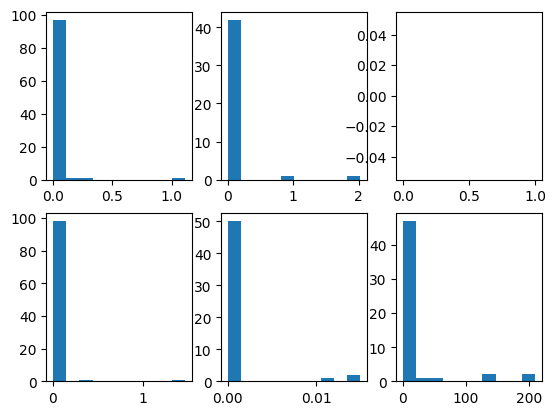

In [560]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(time_summary_int["Model free test"].dropna())
axs[0, 1].hist(time_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(time_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(time_summary_ind["Model free test"].dropna())
axs[1, 1].hist(time_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(time_summary_ind["Ind. Telegraph"].dropna())

(array([44.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  4.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

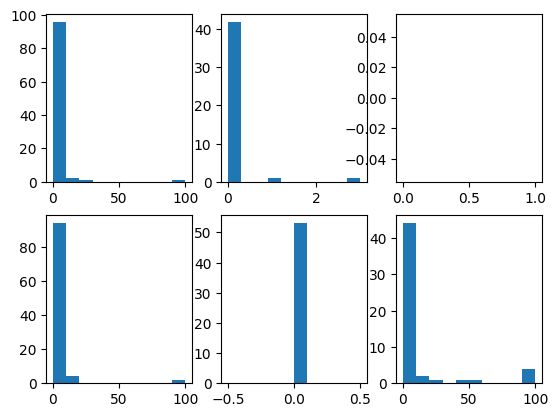

In [561]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(cuts_summary_int["Model free test"].dropna())
axs[0, 1].hist(cuts_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(cuts_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(cuts_summary_ind["Model free test"].dropna())
axs[1, 1].hist(cuts_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(cuts_summary_ind["Ind. Telegraph"].dropna())

## d = 3

In [539]:
sankey_from_df(result_summary_int)

In [540]:
sankey_from_df(result_summary_ind)

(array([47.,  4.,  4.,  2.,  5.,  2.,  1.,  2.,  2.,  1.]),
 array([0.        , 0.06110003, 0.12220006, 0.18330009, 0.24440012,
        0.30550015, 0.36660018, 0.42770021, 0.48880024, 0.54990027,
        0.6110003 ]),
 <BarContainer object of 10 artists>)

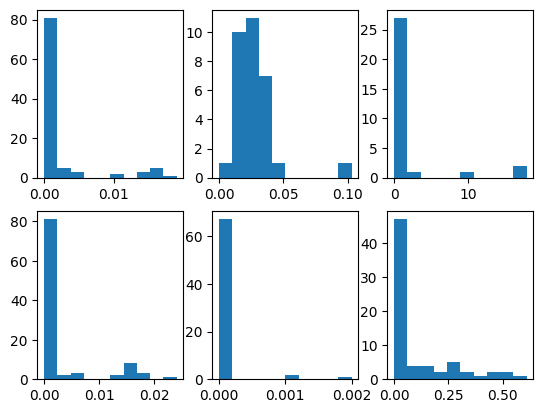

In [541]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(time_summary_int["Model free test"].dropna())
axs[0, 1].hist(time_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(time_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(time_summary_ind["Model free test"].dropna())
axs[1, 1].hist(time_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(time_summary_ind["Ind. Telegraph"].dropna())

(array([37.,  8.,  4.,  0., 10.,  5.,  0.,  3.,  2.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

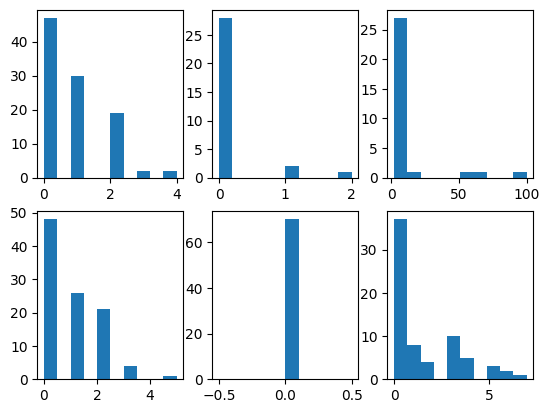

In [542]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(cuts_summary_int["Model free test"].dropna())
axs[0, 1].hist(cuts_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(cuts_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(cuts_summary_ind["Model free test"].dropna())
axs[1, 1].hist(cuts_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(cuts_summary_ind["Ind. Telegraph"].dropna())

## d = 2

In [522]:
sankey_from_df(result_summary_int)

In [523]:
sankey_from_df(result_summary_ind)

(array([15.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  2.]),
 array([0.        , 0.00020001, 0.00040002, 0.00060003, 0.00080004,
        0.00100005, 0.00120006, 0.00140007, 0.00160007, 0.00180008,
        0.00200009]),
 <BarContainer object of 10 artists>)

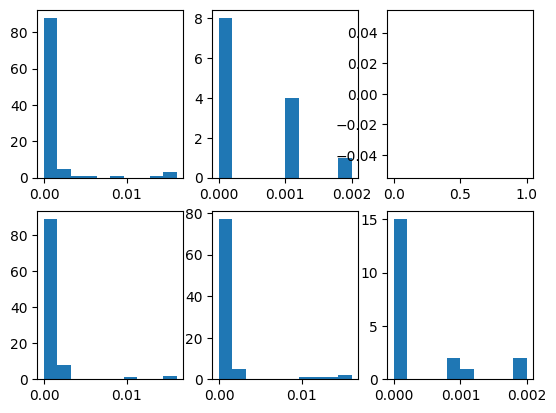

In [520]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(time_summary_int["Model free test"].dropna())
axs[0, 1].hist(time_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(time_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(time_summary_ind["Model free test"].dropna())
axs[1, 1].hist(time_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(time_summary_ind["Ind. Telegraph"].dropna())

(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

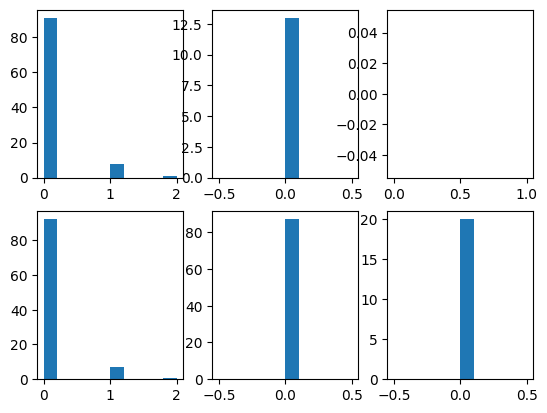

In [521]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(cuts_summary_int["Model free test"].dropna())
axs[0, 1].hist(cuts_summary_int["Int. Birth-Death"].dropna())
axs[0, 2].hist(cuts_summary_int["Int. Telegraph"].dropna())
axs[1, 0].hist(cuts_summary_ind["Model free test"].dropna())
axs[1, 1].hist(cuts_summary_ind["Ind. Birth-Death"].dropna())
axs[1, 2].hist(cuts_summary_ind["Ind. Telegraph"].dropna())

# Birth-Death infeasibility inspection

In [382]:
# genes
genes = 1000
k = 0

data = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[:genes], beta)
data.bootstrap(d=2, tqdm_disable=False)

E_b = np.mean(beta)
E2_b = np.mean(beta**2)

means = []
variances = []

for s in range(genes):
    bounds = data.moment_bounds[f'sample-{s}']
    E_x_OB = np.mean(bounds[:, 2])
    E2_x_OB = np.mean(bounds[:, 5])
    E_x_OG = E_x_OB / E_b
    E2_x_OG = (E2_x_OB - E_x_OB*(1 - E2_b/E_b)) / E2_b
    V_x_OG = E2_x_OG - E_x_OG**2
    means.append(E_x_OG)
    variances.append(V_x_OG)

100%|██████████| 1000/1000 [00:16<00:00, 62.21it/s]


C:\Users\willi\AppData\Local\Temp\ipykernel_8536\3580549126.py:1: RuntimeWarning:

invalid value encountered in log10



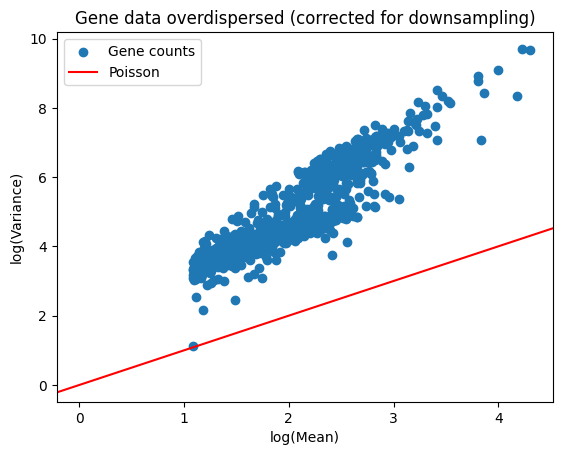

In [575]:
plt.scatter(np.log10(means), np.log10(variances), label="Gene counts")
plt.axline([0, 0], [1, 1], color="red", label="Poisson")
plt.xlabel("log(Mean)")
plt.ylabel("log(Variance)")
plt.title("Gene data overdispersed (corrected for downsampling)")
plt.legend()

# Single runs

In [454]:
# genes
k = 40

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_s = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+1], beta)

# order
d = 4

# bootstrap
dataset_s.bootstrap(d=d, tqdm_disable=False)

100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


In [455]:
#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=False
)
fixed = [(3, 1)]#, (7, 1), (8, 0)]

# test feasibility
opt_S = optimization.TelegraphOptimization(dataset_s, d, constraints=constraints, silent=True, fixed=fixed)
opt_S.analyse_dataset()

opt_S.result_dict

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


{0: {'status': 'OPTIMAL', 'time': 8.590999841690063, 'cuts': 7}}

In [456]:
opt_S.optim_times_dict

{0: [0.021999835968017578,
  0.021999835968017578,
  1.1659998893737793,
  2.0470001697540283,
  0.5109999179840088,
  1.9000000953674316,
  1.3289999961853027,
  0.3489999771118164,
  1.2669999599456787]}

# Order comparison

In [472]:
from matplotlib.colors import LinearSegmentedColormap

In [573]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_d = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+genes], beta)

# order
d_max = 6

# bootstrap
dataset_d.bootstrap(d=d_max, tqdm_disable=False)

#settings
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

results = np.zeros((genes, d_max - 1))

result_summary_d = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=[f"Order d = {d}" for d in range(2, d_max + 1)]
)

time_summary_d = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=[f"Order d = {d}" for d in range(2, d_max + 1)]
)

cuts_summary_d = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=[f"Order d = {d}" for d in range(2, d_max + 1)]
)

for d in range(2, d_max + 1):

    # test feasibility
    opt_MF_d = optimization.ModelFreeOptimization(dataset_d, d, constraints=constraints, printing=False, silent=True)
    opt_MF_d.analyse_dataset()

    for gene, sol in opt_MF_d.result_dict.items():
        if sol['status'] == "INFEASIBLE":
            results[gene, d - 2] = 1 
        result_summary_d.iloc[gene, d - 2] = text_map_mf(sol['status'])
        time_summary_d.iloc[gene, d - 2] = sol['time']
        cuts_summary_d.iloc[gene, d - 2] = sol['cuts']

100%|██████████| 100/100 [43:32<00:00, 26.13s/it]  


In [574]:
sankey_from_df(result_summary_d)

In [572]:
sankey_from_df(result_summary_d)

In [563]:
sankey_from_df(result_summary_d)

Text(0, 0.5, 'Cutting plane histograms')

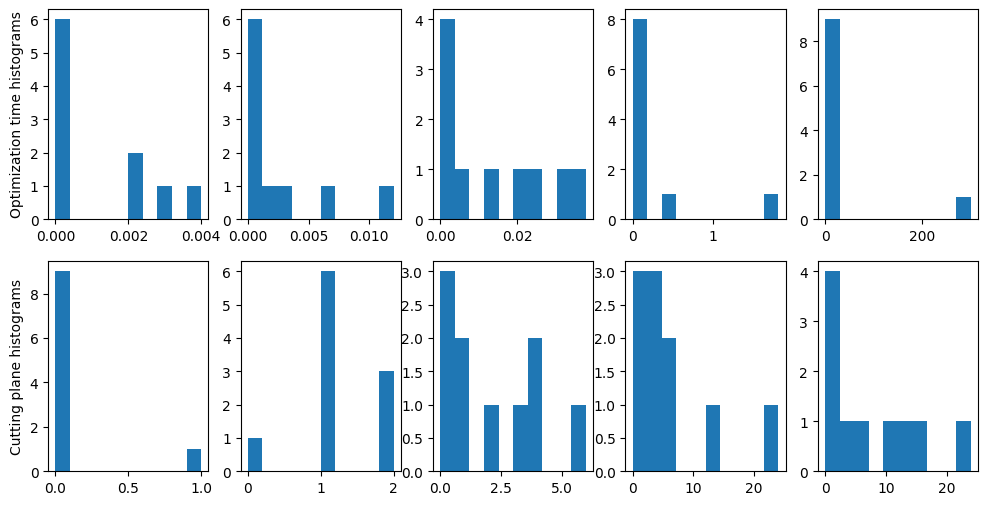

In [570]:
fig, axs = plt.subplots(2, d_max + 1 - 2, figsize=(12, 6))
for d in range(2, d_max + 1):
    axs[0, d - 2].hist(time_summary_d[f"Order d = {d}"])
    axs[1, d - 2].hist(cuts_summary_d[f"Order d = {d}"])
axs[0, 0].set_ylabel("Optimization time histograms")
axs[1, 0].set_ylabel("Cutting plane histograms")

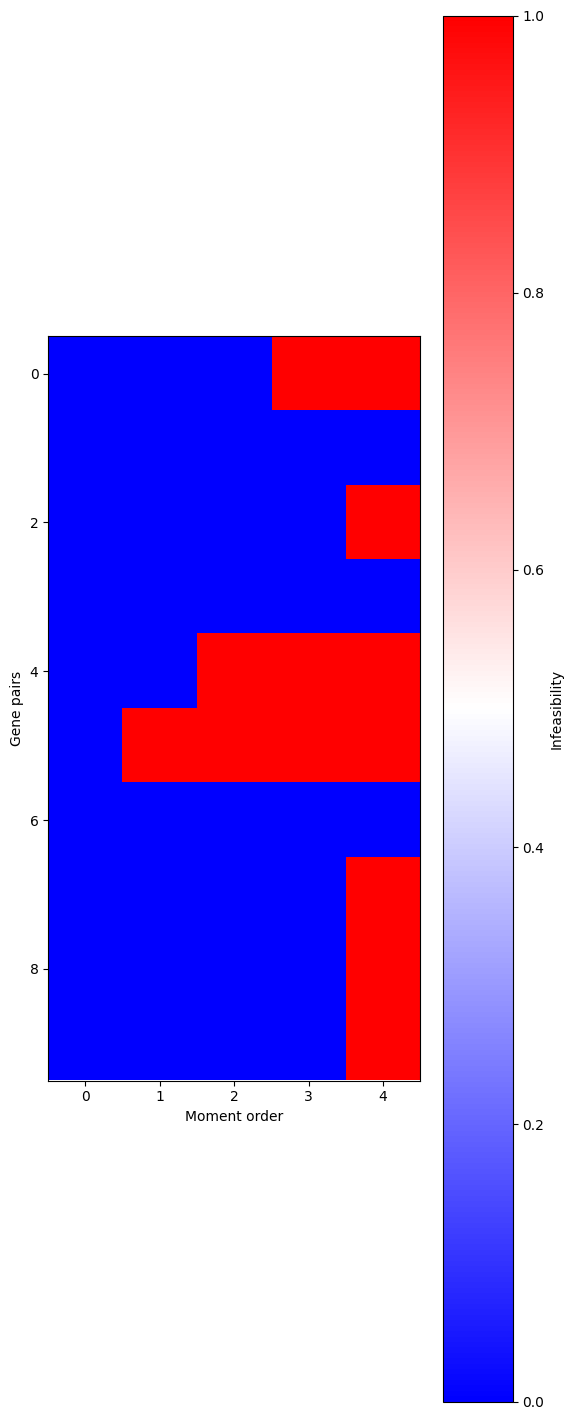

In [495]:
fig, axs = plt.subplots(figsize=(6, 18))
cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)
vmin, vmax = 0, 1
img = axs.imshow(results, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_xlabel("Moment order")
axs.set_ylabel("Gene pairs")
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("Infeasibility")